# Prediction Models (classification / regression)

In [1]:
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler, MultiLabelBinarizer, PolynomialFeatures, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Preprocessing

In [2]:
df = pd.read_csv("./../../data/goodreads_data.csv", converters={"genres": lambda x: x[1:-1].split(",")})
df["publication_date"] = pd.to_datetime(df["published"].apply(lambda x: " ".join(str(x).split()[:3])), errors="coerce")
df["publication_year"] = df["publication_date"].dt.year.astype("float")
df["n_pages"] = df["pages_format"].apply(lambda x: int(x.split()[0]) if x.split()[0].isdigit() else np.nan).astype("float")
df["format"] = df["pages_format"].apply(lambda x: x.replace("Kindle Edition", "Kindle").split()[-1].lower() if x.replace("Kindle Edition", "Kindle").split()[-1].lower() in ["hardcover", "paperback", "ebook", "audiobook", "audio", "cd", "kindle"] else "other").astype("category")

dic_rating = {1: "one_star", 2: "two_stars", 3: "three_stars", 4: "four_stars", 5: "five_stars"}
for key, value in dic_rating.items():
    df[value] = df["ratings"].apply(lambda x: float(x[1:-1].split(",")[key-1])) / df["n_ratings"]
df["average_rating"] = df["ratings"].apply(lambda x: sum([(i+1) * float(x[1:-1].split(",")[i]) for i in range(5)])) / df["n_ratings"]

df.head(5)

,title,author,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
0,The Weed That Strings the Hangman's Bag,Alan Bradley,4.99,From Dagger Award-winning and internationally ...,Librarian Note: There is more than one author ...,"['Mystery', 'Fiction', 'Historical Fiction',...",55692.0,5756.0,"[395.0, 1540.0, 12237.0, 25714.0, 15806.0]","364 pages, Hardcover",...,NaN,2010-03-09,2010.0,364.0,0.007093,0.027652,0.219726,0.461718,0.283811,3.987503
1,A Good Man in Africa,William Boyd,11.99,"In the small African republic of Kinjanja, Bri...","Note: William^^BoydOf Scottish descent, Boyd w...","['Fiction', 'Africa', 'Humor', 'Novels', '...",5018.0,298.0,"[90.0, 257.0, 1222.0, 2184.0, 1265.0]","352 pages, Paperback",...,['Kinjanja'],2003-01-14,2003.0,352.0,0.017935,0.051216,0.243523,0.435233,0.252092,3.852332
2,It Had to Be You,Janice Thompson,0.00,Bella couldn't be happier that her long-feudin...,"Welcome to the wacky, wonderful world of inspi...","['Christian Fiction', 'Romance', 'Christian'...",2152.0,132.0,"[14.0, 86.0, 421.0, 735.0, 896.0]","336 pages, Paperback",...,"['Galveston, Texas']",2010-05-01,2010.0,336.0,0.006506,0.039963,0.195632,0.341543,0.416357,4.121283
3,Missing,Kelley Armstrong,6.99,Everyone knows they left. No one knows they're...,Kelley Armstrong has been telling stories sinc...,"['Young Adult', 'Mystery', 'Thriller', 'Fic...",3393.0,491.0,"[54.0, 185.0, 799.0, 1308.0, 1047.0]","515 pages, ebook",...,NaN,2017-04-18,2017.0,515.0,0.015915,0.054524,0.235485,0.385500,0.308576,3.916298
4,Dawn of Rebellion,Michelle Lynn,0.00,"My name is Dawn Nolan, and I've grown up on th...",Michelle moved around the Midwest most of her ...,"['Young Adult', 'Dystopia', 'Romance', 'Sci...",142.0,76.0,"[1.0, 6.0, 23.0, 41.0, 71.0]","321 pages, Paperback",...,NaN,2013-10-17,2013.0,321.0,0.007042,0.042254,0.161972,0.288732,0.500000,4.232394


In [3]:
print("Number of books (with duplicates): ", len(df))
df.drop_duplicates(subset=["title", "author"], keep='first', inplace=True, ignore_index=True)
print("Number of books (without duplicates): ", len(df))

Number of books (with duplicates):  24630
Number of books (without duplicates):  19666


## Formats Classification

In [31]:
features = ["price", "n_ratings", "n_reviews", "publication_year", "n_pages", "average_rating"]
print("Number of features: ", len(features))

Number of features:  6


In [32]:
df_format = df[features + ["format"]].dropna()

X_format = df_format[features].values
X_format = MinMaxScaler().fit_transform(X_format)

lb = LabelEncoder()
y_format = lb.fit_transform(df_format["format"].values)

print("Number of classes: ", len(lb.classes_))

Number of classes:  8


In [33]:
scores = {}

### K Nearest Neighbors

In [34]:
params = {
    "n_neighbors": range(3, 21, 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

gridsearch = GridSearchCV(KNeighborsClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["KNN"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best score:  0.6054517446729996


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Logistic Regression

In [35]:
params = {
    "max_iter": [500, 1000, 2000],
    "C": [0.1, 1, 10, 100],
    "class_weight": ["balanced", None],
    "solver": ["liblinear", "lbfgs"]
}

gridsearch = GridSearchCV(LogisticRegression(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["LogisticRegression"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'C': 100, 'class_weight': None, 'max_iter': 500, 'solver': 'liblinear'}
Best score:  0.5767803948477317


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Decision Tree

In [36]:
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(3, 11),
}

gridsearch = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["DecisionTree"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'criterion': 'gini', 'max_depth': 7}
Best score:  0.617433589665569


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


[Text(0.4721563981042654, 0.9375, 'publication_year <= 0.911\ngini = 0.636\nsamples = 19113\nvalue = [8.0, 36.0, 55.0, 945.0, 5177.0, 2739.0, 265.0, 9888.0]\nclass = paperback'),
 Text(0.22985781990521326, 0.8125, 'publication_year <= 0.9\ngini = 0.357\nsamples = 7421\nvalue = [0, 5, 11, 28, 1487, 39, 91, 5760]\nclass = paperback'),
 Text(0.11670616113744076, 0.6875, 'publication_year <= 0.716\ngini = 0.3\nsamples = 5761\nvalue = [0, 3, 2, 18, 899, 26, 80, 4733]\nclass = paperback'),
 Text(0.0485781990521327, 0.5625, 'average_rating <= 0.528\ngini = 0.57\nsamples = 186\nvalue = [0, 0, 0, 3, 86, 2, 9, 86]\nclass = hardcover'),
 Text(0.023696682464454975, 0.4375, 'n_pages <= 0.005\ngini = 0.497\nsamples = 29\nvalue = [0, 0, 0, 2, 3, 1, 3, 20]\nclass = paperback'),
 Text(0.009478672985781991, 0.3125, 'price <= 0.005\ngini = 0.625\nsamples = 4\nvalue = [0, 0, 0, 1, 0, 1, 2, 0]\nclass = other'),
 Text(0.004739336492890996, 0.1875, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 0, 0, 0, 0, 2, 0]\n

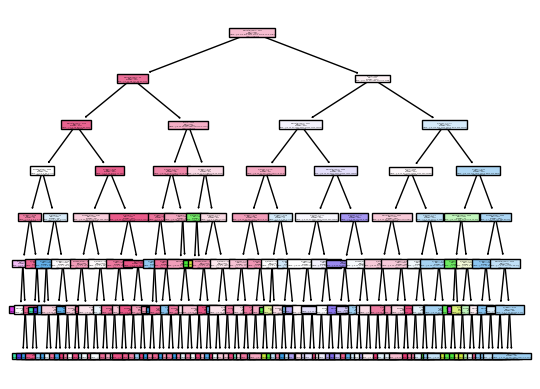

In [37]:
plot_tree(gridsearch.best_estimator_, feature_names=features, class_names=lb.classes_, filled=True)

### Random Forest

In [38]:
params = {
    "n_estimators": [100, 250, 500],
    "max_depth": [50, 100, None]
}

gridsearch = GridSearchCV(RandomForestClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["RandomForest"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'max_depth': None, 'n_estimators': 500}
Best score:  0.6321353048754864


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Support Vector Classifier

In [39]:
params = {
    "C": [1, 10, 100],
    "kernel": ["rbf", "sigmoid"],
    "degree": range(2, 5),
}

gridsearch = GridSearchCV(SVC(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["SVC"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'C': 100, 'degree': 2, 'kernel': 'rbf'}
Best score:  0.5863023565127373


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Models Comparison

In [40]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tAccuracy: p = {p:.5f}")

Comparing KNN and LogisticRegression
	Accuracy: p = 0.00000
Comparing KNN and DecisionTree
	Accuracy: p = 0.00310
Comparing KNN and RandomForest
	Accuracy: p = 0.00000
Comparing KNN and SVC
	Accuracy: p = 0.00003
Comparing LogisticRegression and DecisionTree
	Accuracy: p = 0.00000
Comparing LogisticRegression and RandomForest
	Accuracy: p = 0.00000
Comparing LogisticRegression and SVC
	Accuracy: p = 0.00323
Comparing DecisionTree and RandomForest
	Accuracy: p = 0.00105
Comparing DecisionTree and SVC
	Accuracy: p = 0.00000
Comparing RandomForest and SVC
	Accuracy: p = 0.00000


## Genres Classification

In [41]:
features = ["price", "n_ratings", "n_reviews", "publication_year", "n_pages", "average_rating"]
print("Number of features: ", len(features))

Number of features:  6


In [42]:
df_genres = df[features + ["genres"]].dropna()

X_genres = df_genres[features].values
X_genres = MinMaxScaler().fit_transform(X_genres)

mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(df_genres["genres"].values)

print("Number of classes: ", len(mlb.classes_))

Number of classes:  1076


In [43]:
scores = {}

### K Nearest Neighbors

In [45]:
params = {
    "n_neighbors": range(15, 21, 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

gridsearch = GridSearchCV(KNeighborsClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_genres, y_genres)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["KNN"] = cross_val_score(gridsearch.best_estimator_, X_genres, y_genres, cv=10)

KeyboardInterrupt: 

### Logistic Regression

In [47]:
params = {
    "max_iter": [500, 1000, 2000],
    "C": [0.1, 1, 10, 100],
    "class_weight": ["balanced", None],
    "solver": ["liblinear", "lbfgs"]
}

gridsearch = GridSearchCV(LogisticRegression(), params, cv=5)
gridsearch = gridsearch.fit(X_genres, y_genres)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["LogisticRegression"] = cross_val_score(gridsearch.best_estimator_, X_genres, y_genres, cv=10)

ValueError: 
All the 240 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1201, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1279, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1300, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1367, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (15290, 1076) instead.

--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py", line 1201, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1279, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1300, in _check_y
    y = column_or_1d(y, warn=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py", line 1367, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (15291, 1076) instead.


### Decision Tree

In [48]:
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(3, 11),
}

gridsearch = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_genres, y_genres)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["DecisionTree"] = cross_val_score(gridsearch.best_estimator_, X_genres, y_genres, cv=10)

Best parameters:  {'criterion': 'gini', 'max_depth': 10}
Best score:  0.0005755190464282053


In [ ]:
plot_tree(gridsearch.best_estimator_, feature_names=features, class_names=lb.classes_, filled=True)

### Random Forest

In [ ]:
params = {
    "n_estimators": [100, 250, 500],
    "max_depth": [50, 100, None]
}

gridsearch = GridSearchCV(RandomForestClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_genres, y_genres)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["RandomForest"] = cross_val_score(gridsearch.best_estimator_, X_genres, y_genres, cv=10)

### Models Comparison

In [ ]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tAccuracy: p = {p:.5f}")

## Prices Prediction

In [ ]:
features = ["n_ratings", "n_reviews", "publication_year", "n_pages", "average_rating"]
print("Number of features: ", len(features))

Number of features:  5


In [ ]:
df_prices = df[features + ["price"]]
df_prices = (df_prices - df_prices.mean()) / df_prices.std()

In [ ]:
mlb = MultiLabelBinarizer()
df_genres_one_hot = pd.DataFrame(mlb.fit_transform(df["genres"]), columns=mlb.classes_, index=df.index)

lb = LabelBinarizer()
df_format_one_hot = pd.DataFrame(lb.fit_transform(df["format"]), columns=lb.classes_, index=df.index)

In [ ]:
df_prices = pd.concat([df_prices, df_genres_one_hot, df_format_one_hot], axis=1)
df_prices = df_prices.dropna()

df_prices.head(5)

,n_ratings,n_reviews,publication_year,n_pages,average_rating,price,'...more','12th Century','13th Century','14th Century',...,'Zambia','Zombies',audio,audiobook,cd,ebook,hardcover,kindle,other,paperback
0,0.101439,0.421215,0.179883,0.162318,-0.000783,-0.418172,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.153332,-0.215356,-0.487601,0.109364,-0.489705,0.654207,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.167741,-0.234717,0.179883,0.038760,0.483106,-1.182625,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.161502,-0.192847,0.847367,0.828646,-0.258333,-0.111778,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-0.177847,-0.241248,0.465947,-0.027432,0.885004,-1.182625,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_prices = df_prices[df_prices.columns.difference(["price"])].values
y_prices = df_prices["price"].values

In [ ]:
scores = {}

### Linear Regression

In [ ]:
scores["LinearRegression"] = cross_val_score(LinearRegression(), X_prices, y_prices, cv=10)

### Support Vector Regression

In [ ]:
params = {
    "C": [0.1, 1, 10],
    "kernel": ["rbf", "sigmoid"],
    "degree": range(2, 5),
}

gridsearch = GridSearchCV(SVR(), params, cv=5)
gridsearch = gridsearch.fit(X_prices, y_prices)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["SVR"] = cross_val_score(gridsearch.best_estimator_, X_prices, y_prices, cv=10)

### Models Comparison

In [ ]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tAccuracy: p = {p:.5f}")

## Ratings Prediction

In [4]:
features = ["price", "n_ratings", "n_reviews", "publication_year", "n_pages"]
print("Number of features: ", len(features))

Number of features:  5


In [10]:
df_ratings = df[features + ["average_rating"]].dropna()
df_ratings = (df_ratings - df_ratings.mean()) / df_ratings.std()

In [11]:
X_ratings = df_ratings[features].values
y_ratings = df_ratings["average_rating"].values

In [12]:
scores = {}

### Linear Regression

In [13]:
scores["LinearRegression"] = cross_val_score(LinearRegression(), X_ratings, y_ratings, cv=10)

### Support Vector Regression

In [19]:
params = {
    "C": [0.1, 1, 10],
    "kernel": ["rbf", "sigmoid"],
    "degree": range(2, 10),
}

gridsearch = GridSearchCV(SVR(), params, cv=5)
gridsearch = gridsearch.fit(X_ratings, y_ratings)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["SVR"] = cross_val_score(gridsearch.best_estimator_, X_ratings, y_ratings, cv=10)

### Models Comparison

In [17]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tp = {p:.5f}")

Comparing LinearRegression and SVR
	p = 0.00000


In [ ]:
print(scores)

{'LinearRegression': array([-0.00335131,  0.03877197,  0.0295104 ,  0.03388785,  0.03109899,
        0.01950547,  0.02612045, -0.02493832,  0.02223991,  0.02578424]), 'SVR': array([0.10771509, 0.13500509, 0.10265311, 0.12967594, 0.11753781,
       0.10040945, 0.12694459, 0.10609586, 0.13315985, 0.10748348])}
